In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random
from tqdm import tqdm

In [77]:
resolution = 592.747
round_resolution = round(resolution)
image_path = 'dataset/images/'
label_path = image_path.replace('images', 'labels')
image_names = os.listdir(label_path)

28_-121_v
14_-98_h
8_-112_h


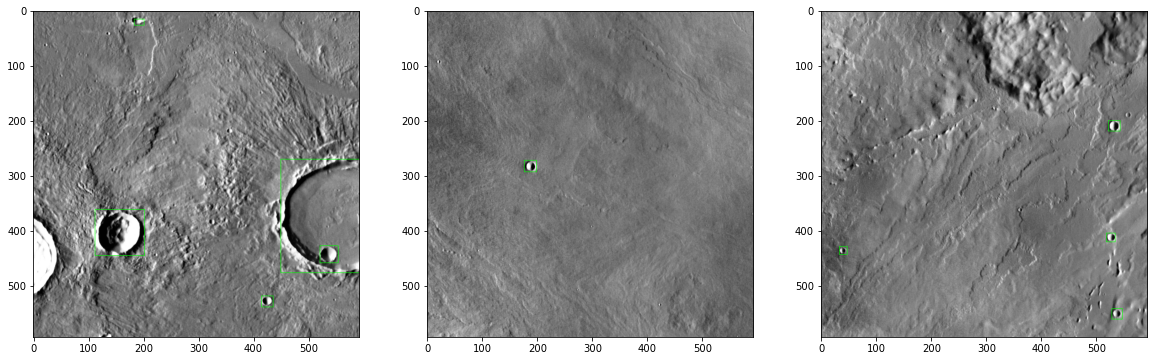

In [97]:
random.shuffle(image_names)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    image_name = image_names[i][:-4]
    im = cv2.imread(image_path + image_name + '.png')
    label_name = image_name + '.txt'
    print(image_name)
    f = open(label_path + label_name, 'r')
    for line in f.readlines():
        c, x, y, w, h, id = line.split(' ')
        x1 = int((float(x) - float(w) / 2) * 593)
        y1 = int((float(y) - float(h) / 2) * 593)
        x2 = int((float(x) + float(w) / 2) * 593)
        y2 = int((float(y) + float(h) / 2) * 593)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 1)
    f.close()
    ax[i].imshow(im)

In [20]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_list = os.listdir('dataset/images')

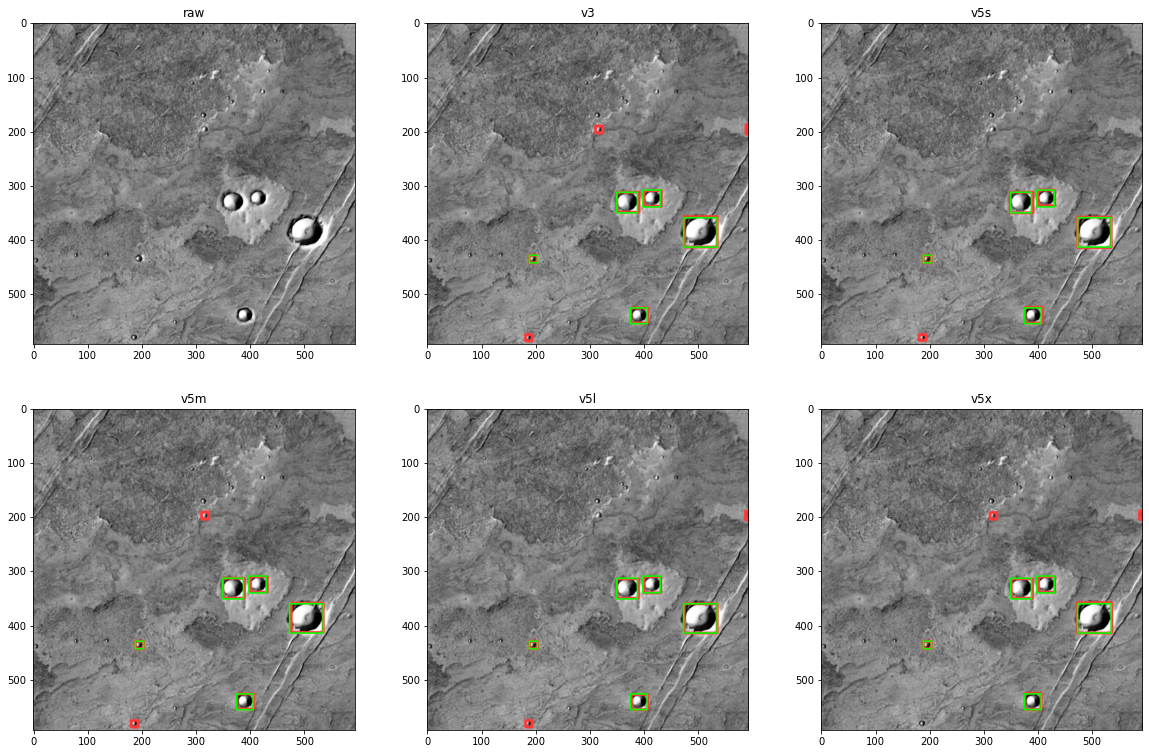

In [39]:
random.shuffle(image_list)
for image_name in image_list[:1]:
    plt.figure(figsize=(20, 13))

    # origin pic
    plt.subplot(2, 3, 1)
    raw_pic = mpimg.imread('dataset/images/' + image_name)
    plt.imshow(raw_pic, cmap='gray')
    plt.title('raw')

    # v3
    plt.subplot(2, 3, 2)
    pic = mpimg.imread('detect/v3/' + image_name)
    plt.imshow(pic)
    plt.title('v3')

    # v5s
    plt.subplot(2, 3, 3)
    pic = mpimg.imread('detect/v5s/' + image_name)
    plt.imshow(pic)
    plt.title('v5s')

    # v5m
    plt.subplot(2, 3, 4)
    pic = mpimg.imread('detect/v5m/' + image_name)
    plt.imshow(pic)
    plt.title('v5m')

    # v5l
    plt.subplot(2, 3, 5)
    pic = mpimg.imread('detect/v5l/' + image_name)
    plt.imshow(pic)
    plt.title('v5l')

    # v5x
    plt.subplot(2, 3, 6)
    pic = mpimg.imread('detect/v5x/' + image_name)
    plt.imshow(pic)
    plt.title('v5x')

# Select 2a2b dataset

In [2]:
# f = open('combined/loss_rank.csv', 'r')
# print(f.readline())
# rank = [(line.split(',')[0], *[float(loss) for loss in line.split(',')[1:]]) for line in f.read().splitlines()]
# f.close()

rank = pd.read_csv('combined/loss_rank.csv')
rank.columns

Index(['img', 'box', 'obj', 'cls', 'loss'], dtype='object')

In [30]:
index = np.array(rank['box'] < 0.0103) & np.array(rank['obj'] < 0.005)
data_2a = rank[index]
data_2a_set = set('_'.join(name.split('_')[:2]) for name in data_2a['img'])
len(data_2a_set) / len(rank) * 4

0.19894179894179895

In [46]:
index = np.array(rank['box'] < 0.03) & np.array(rank['obj'] > 0.023)
data_2b = rank[index]
data_2b_set = set('_'.join(name.split('_')[:2]) for name in data_2b['img'])
len(data_2b_set) / len(rank) * 4

0.1984126984126984

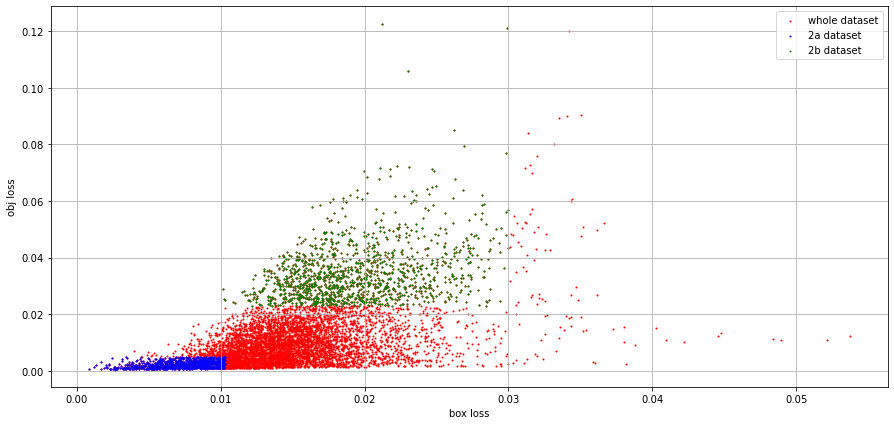

In [47]:
plt.figure(figsize=(15,7))
plt.scatter(rank['box'], rank['obj'], s=1, color='r', label='whole dataset')
plt.scatter(data_2a['box'], data_2a['obj'], s=1, color='b', label='2a dataset')
plt.scatter(data_2b['box'], data_2b['obj'], s=1, color='g', label='2b dataset')
plt.grid()
plt.xlabel('box loss')
plt.ylabel('obj loss')
plt.legend()
plt.show()

# Count confidence

In [1]:
def xywh2xyxy(x, y, w, h):
    x, y, w, h = float(x), float(y), float(w), float(h)
    return x - w / 2, y - h / 2, x + w / 2, y + h / 2

# calculate area of a box
def area(x1, y1, x2, y2):
    return (x2 - x1) * (y2 - y1)

# calculate iou of two boxes
def iou(box1, box2):
    '''
    box1 = [x1, y1, x2, y2]
    box2 = [x1, y1, x2, y2]
    '''
    # calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # no overlap
    if x1 > x2 or y1 > y2:
        return 0.
    
    intersection_area = area(x1, y1, x2, y2)
    union_area = area(*box1) + area(*box2) - intersection_area
    
    return intersection_area / union_area


def count_true_false(image_name_list, path):

    true_list = []
    false_list = []

    for img_name in tqdm(image_name_list):
        gt_label_file = open(path + '/labels/' + img_name[:-4] + '.txt', 'r')

        gt_labels = []
        # show gt labels
        for line in gt_label_file.read().splitlines():
            x1, y1, x2, y2 = xywh2xyxy(*line.split()[1: 5])
            gt_labels.append((x1, y1, x2, y2))
        
        gt_label_file.close()

        

        yolo_label_file = open(path + '/yolo_labels/' + img_name[:-4] + '.txt', 'r')
        for line in yolo_label_file.read().splitlines():
            x1, y1, x2, y2 = xywh2xyxy(*line.split()[1: 5])
            conf = float(line.split()[5])
            ratio = (x2 - x1) / (y2 - y1)
            if conf < 0.1 or ratio > 2 or ratio < 0.5:
                continue
            for gt_label in gt_labels:
                if iou(gt_label, (x1, y1, x2, y2)) >= 0.3:
                    true_list.append(conf)
                    conf = 100
                    break
            if conf != 100:
                false_list.append(conf)

        yolo_label_file.close()

    

    return true_list, false_list

In [2]:


f = open('combined/data_2a.txt')
t_2a, f_2a = count_true_false(f.read().splitlines(), 'combined')
f.close()

f = open('combined/data_2b.txt')
t_2b, f_2b = count_true_false(f.read().splitlines(), 'combined')
f.close()


t_ben, f_ben = count_true_false(os.listdir('bendix/yolo_labels'), 'bendix')
f.close()



100%|██████████| 3409/3409 [00:00<00:00, 4288.19it/s]


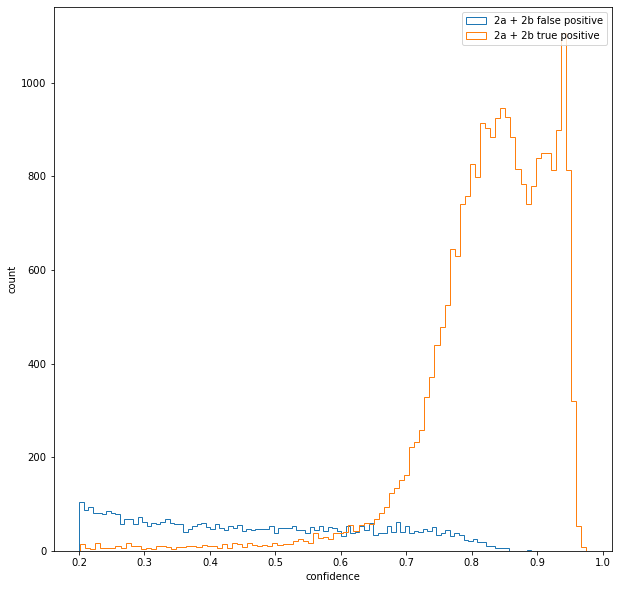

In [6]:

plt.figure(figsize=(10,10))
# plt.hist(f_2a, bins=100, label='2a false positive', histtype='step')
# plt.hist(t_2a, bins=100, label='2a true positive', histtype='step')
# plt.hist(f_2b, bins=100, label='2b false positive', histtype='step')
# plt.hist(t_2b, bins=100, label='2b true positive', histtype='step')
plt.hist(f_2b + f_2a, bins=100, label='2a + 2b false positive', histtype='step')
plt.hist(t_2b + t_2a, bins=100, label='2a + 2b true positive', histtype='step')

# plt.hist(f_ben, bins=100, label='bendix false positive', histtype='step')
# plt.hist(t_ben, bins=100, label='bendix true positive', histtype='step')

plt.legend()
plt.xlabel('confidence')
plt.ylabel('count')
plt.show()

# select bendix top 10% test set